[*********************100%***********************]  1 of 1 completed


Price            Open       High        Low      Close      Price     Volume
Ticker           AAPL       AAPL       AAPL       AAPL                  AAPL
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  27.332500  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  26.562500  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  26.565001  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  26.937500  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  27.972500  237458000
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Root Mean Squared Error: 2.0447315488713502
R² Score: 0.9989723492415793


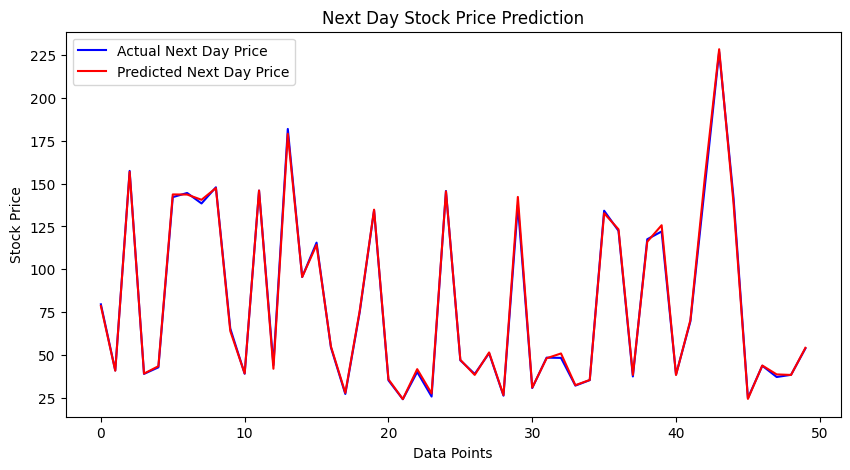

Predicted Stock Price for the Next Day: 247.33


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


# Load the dataset
import yfinance as yf

# Fetch data for Reliance Industries from NSE
stock_ticker = "AAPL"  # NSE ticker
data = yf.download(stock_ticker, start="2015-01-01", end="2024-12-17")

# Replace Adj Close with Close for accuracy
data['Price'] = data['Close']

# Display first 5 rows
print(data[['Open', 'High', 'Low', 'Close', 'Price', 'Volume']].head())

# Feature engineering
data['High-Low'] = data['High'] - data['Low']
data['Open-Close'] = data['Open'] - data['Close']
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()



# Relative Strength Index (RSI)
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['Close'])

# Moving Average Convergence Divergence (MACD)
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Average True Range (ATR)
data['TR'] = data[['High', 'Low', 'Close']].max(axis=1) - data[['High', 'Low', 'Close']].min(axis=1)
data['ATR'] = data['TR'].rolling(window=14).mean()

# Lag features
for lag in range(1, 11):
    data[f'Lag_{lag}'] = data['Close'].shift(lag)

    # ... (previous code) ...

# Calculate Bollinger Bands
data['MA_20'] = data['Close'].rolling(window=20).mean() # Calculate 20-day moving average
data['Std_Dev_20'] = data['Close'].rolling(window=20).std() # Calculate 20-day standard deviation
data['Bollinger_High'] = data['MA_20'] + 2 * data['Std_Dev_20'] # Calculate upper Bollinger Band
data['Bollinger_Low'] = data['MA_20'] - 2 * data['Std_Dev_20'] # Calculate lower Bollinger Band


# ... (rest of the code) ...

# Shift the target variable (Close price) by -1 to predict the next day’s price
data['Next_Day_Close'] = data['Close'].shift(-1)

# Drop rows with NaN values
data = data.dropna()

# Define features (X) and target (y)
features = [
    'Open', 'High', 'Low', 'Volume', 'High-Low', 'Open-Close', 'MA_10', 'MA_50',
   'RSI', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low',
    'ATR'
] + [f'Lag_{lag}' for lag in range(1, 11)]
X = data[features]
y = data['Next_Day_Close']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with best parameters
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:50], label="Actual Next Day Price", color="blue")
plt.plot(y_pred[:50], label="Predicted Next Day Price", color="red")
plt.title("Next Day Stock Price Prediction")
plt.xlabel("Data Points")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Predict the next day’s stock price
latest_features = scaler.transform([X.iloc[-1].values])
predicted_next_day_price = model.predict(latest_features)

# Print the prediction
print(f"Predicted Stock Price for the Next Day: {predicted_next_day_price[0]:.2f}")
